In [1]:
from src.libs.lib import *
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#2.6s

Hash numérica de 5 dígitos: 94799


In [2]:
timeline_file = 'src/data/timeline.csv'
days_file = 'src/data/days.csv'
timeline_df = pd.read_csv(timeline_file)
days_df = pd.read_csv(days_file)
merged_df = pd.merge(timeline_df, days_df, on='ID do contrato', how='left')
merged_df["Quantidade de horas que o contrato sofreu postergação de inicio"].isna().mean()

np.float64(0.5545643187514676)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def gerar_grafico_cancelamentos_por_adiamentos(timeline_file, days_file, tipo_contrato):
    timeline_df = pd.read_csv(timeline_file)
    days_df = pd.read_csv(days_file)

    data_format = '%Y-%m-%d %H:%M:%S'
    timeline_df['Data da criação do contrato'] = pd.to_datetime(timeline_df['Data da criação do contrato'], format=data_format, errors='coerce')
    timeline_df['data do evento'] = pd.to_datetime(timeline_df['data do evento'], format=data_format, errors='coerce')

    df_tipo = timeline_df[timeline_df['tipo de contrato'] == tipo_contrato].copy()
    df_tipo = df_tipo.dropna(subset=['Data da criação do contrato', 'data do evento'])

    merged_df = pd.merge(df_tipo, days_df, on='ID do contrato', how='left')
    merged_df['cancelado'] = merged_df['Nome do evento ocorrido no contrato'] == 'canceled'

    adiamentos_df = merged_df.groupby('ID do contrato')['Nome do evento ocorrido no contrato'].count().reset_index()
    adiamentos_df.rename(columns={'Nome do evento ocorrido no contrato': 'quantidade_adiamentos'}, inplace=True)
    merged_df = pd.merge(merged_df, adiamentos_df, on='ID do contrato', how='left')

    cancelamentos_por_adiamento = merged_df.groupby('quantidade_adiamentos')['cancelado'].mean()
    print(f"\n[{tipo_contrato}] Tabela: Proporção de Cancelamentos por Quantidade de Adiamentos")
    print(cancelamentos_por_adiamento.reset_index())

    cancelamentos_por_adiamento.plot(kind='bar', color='skyblue')
    plt.title(f'[{tipo_contrato}] Cancelamentos por Adiamentos')
    plt.xlabel('Quantidade de Adiamentos')
    plt.ylabel('Proporção de Cancelamentos')
    plt.xticks(rotation=0)
    plt.xlim([0, 10])
    plt.tight_layout()
    plt.show()


import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

def gerar_grafico_ciclo_de_vida(timeline_file, days_file, tipo_contrato):
    timeline_df = pd.read_csv(timeline_file)
    days_df = pd.read_csv(days_file)

    df_tipo = timeline_df[timeline_df['tipo de contrato'] == tipo_contrato].copy()
    data_format = '%Y-%m-%d %H:%M:%S'
    df_tipo['Data da criação do contrato'] = pd.to_datetime(df_tipo['Data da criação do contrato'], format=data_format, errors='coerce')
    df_tipo['data do evento'] = pd.to_datetime(df_tipo['data do evento'], format=data_format, errors='coerce')

    merged_df = pd.merge(df_tipo, days_df, on='ID do contrato', how='left')
    merged_df['tempo_decorrido'] = (merged_df['data do evento'] - merged_df['Data da criação do contrato']).dt.total_seconds() / 3600

    # Janelas de 24h até 5 dias (120h)
    janelas = list(range(24, 30*24, 24))

    status = {
        'freight_completed': 'Atendido',
        'start_at_change': 'Postergado',
        'canceled': 'Cancelado',
    }

    N = merged_df["ID do contrato"].nunique()
    proporcoes = {nome: [] for nome in status.values()}

    for janela in janelas:
        df_janela = merged_df[merged_df['tempo_decorrido'] <= janela]
        for evento, nome_legivel in status.items():
            df_evento = df_janela[df_janela['Nome do evento ocorrido no contrato'] == evento]
            if evento == 'start_at_change':
                df_evento = df_evento[df_evento['Quantidade de horas que o contrato sofreu postergação de inicio'].notna()]
            df_evento_unique = df_evento.drop_duplicates(subset='ID do contrato')
            proporcao = len(df_evento_unique) / N
            proporcoes[nome_legivel].append(proporcao * 100)  # em %

    df_resultado = pd.DataFrame(proporcoes, index=[f"{h}h" for h in janelas])
    print(f"\n[{tipo_contrato}] Tabela: Ciclo de Atendimento dos Contratos (% por janela)")
    print(df_resultado)

    # Gráfico de barras empilhadas com valores
    colors = {
        'Atendido': '#2ecc71',    # verde
        'Cancelado': '#e74c3c',   # vermelho
        'Postergado': '#f1c40f'   # amarelo
    }
    ax = df_resultado.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors[col] for col in df_resultado.columns])

    plt.title(f'[{tipo_contrato}] Ciclo de Atendimento dos Contratos por Janela Temporal (Empilhado)')
    plt.xlabel('Janelas Temporais (Horas)')
    plt.ylabel('Percentual de Contratos (%)')
    plt.xticks(rotation=0)
    plt.legend(title='Status')
    plt.tight_layout()

    # Adiciona os valores nas barras
    for idx, row in df_resultado.iterrows():
        bottom = 0
        for col in df_resultado.columns:
            valor = row[col]
            if valor > 0:
                ax.annotate(f'{valor:.1f}%', (df_resultado.index.get_loc(idx), bottom + valor / 2),
                            ha='center', va='center', fontsize=9, color='black')
            bottom += valor

    plt.show()

    return df_resultado



def gerar_grafico_distribuicao_adiamentos(timeline_file, days_file, tipo_contrato):
    timeline_df = pd.read_csv(timeline_file)
    days_df = pd.read_csv(days_file)

    df_tipo = timeline_df[timeline_df['tipo de contrato'] == tipo_contrato]
    data_format = '%Y-%m-%d %H:%M:%S'
    df_tipo['Data da criação do contrato'] = pd.to_datetime(df_tipo['Data da criação do contrato'], format=data_format, errors='coerce')
    df_tipo['data do evento'] = pd.to_datetime(df_tipo['data do evento'], format=data_format, errors='coerce')

    merged_df = pd.merge(df_tipo, days_df, on='ID do contrato', how='left')
    merged_df = merged_df.dropna(subset=['Quantidade de horas que o contrato sofreu postergação de inicio'])

    janelas = [6, 12, 18, 24, float('inf')]
    nomes_janelas = ['Até 6 horas', '6-12 horas', '12-18 horas', '18-24 horas', '24+ horas']

    contagens = []
    for i, janela in enumerate(janelas):
        if janela == float('inf'):
            contagem = len(merged_df[merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] > janelas[i-1]])
        else:
            if i == 0:
                contagem = len(merged_df[merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] <= janela])
            else:
                contagem = len(merged_df[(merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] > janelas[i-1]) &
                                         (merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] <= janela)])
        contagens.append(contagem)

    df = pd.DataFrame({'Janela': nomes_janelas, 'Total de Adiamentos': contagens})
    print(f"\n[{tipo_contrato}] Tabela: Distribuição dos Adiamentos")
    print(df)

    plt.bar(nomes_janelas, contagens, color='orange')
    plt.title(f'[{tipo_contrato}] Distribuição dos Adiamentos')
    plt.xlabel('Janelas Temporais (Horas)')
    plt.ylabel('Total de Adiamentos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def gerar_grafico_proporcao_cancelamentos_por_adiantamento(timeline_file, days_file, tipo_contrato):
    timeline_df = pd.read_csv(timeline_file)
    days_df = pd.read_csv(days_file)

    data_format = '%Y-%m-%d %H:%M:%S'
    timeline_df['Data da criação do contrato'] = pd.to_datetime(timeline_df['Data da criação do contrato'], format=data_format, errors='coerce')
    timeline_df['data do evento'] = pd.to_datetime(timeline_df['data do evento'], format=data_format, errors='coerce')

    df_tipo = timeline_df[timeline_df['tipo de contrato'] == tipo_contrato].copy()
    df_tipo = df_tipo.dropna(subset=['Data da criação do contrato', 'data do evento'])

    merged_df = pd.merge(df_tipo, days_df, on='ID do contrato', how='left')
    merged_df['cancelado'] = merged_df['Nome do evento ocorrido no contrato'] == 'canceled'

    janelas = [6, 12, 18, 24, float('inf')]
    nomes_janelas = ['Até 6 horas', '6-12 horas', '12-18 horas', '18-24 horas', '24+ horas']
    proporcoes_cancelamento = {}

    for i, janela in enumerate(janelas):
        nome_janela = nomes_janelas[i]
        if janela == float('inf'):
            contratos_com_adiamento = merged_df[merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] > janelas[i-1]]['ID do contrato'].unique()
            contratos_cancelados = merged_df[(merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] > janelas[i-1]) & (merged_df['cancelado'])]['ID do contrato'].unique()
        else:
            if i == 0:
                contratos_com_adiamento = merged_df[merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] <= janela]['ID do contrato'].unique()
                contratos_cancelados = merged_df[(merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] <= janela) & (merged_df['cancelado'])]['ID do contrato'].unique()
            else:
                contratos_com_adiamento = merged_df[(merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] > janelas[i-1]) &
                                                    (merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] <= janela)]['ID do contrato'].unique()
                contratos_cancelados = merged_df[(merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] > janelas[i-1]) &
                                                 (merged_df['Quantidade de horas que o contrato sofreu postergação de inicio'] <= janela) &
                                                 (merged_df['cancelado'])]['ID do contrato'].unique()

        total_contratos_com_adiamento = len(contratos_com_adiamento)
        total_contratos_cancelados = len(contratos_cancelados)
        proporcao = total_contratos_cancelados / total_contratos_com_adiamento if total_contratos_com_adiamento > 0 else 0
        proporcoes_cancelamento[nome_janela] = proporcao

    df = pd.DataFrame(list(proporcoes_cancelamento.items()), columns=['Janela', 'Proporção de Cancelamentos'])
    print(f"\n[{tipo_contrato}] Tabela: Proporção de Cancelamentos por Janela de Adiantamento")
    print(df)

    plt.bar(df['Janela'], df['Proporção de Cancelamentos'], color='red')
    plt.title(f'[{tipo_contrato}] Cancelamentos por Janela de Adiantamento')
    plt.xlabel('Janelas Temporais (Horas)')
    plt.ylabel('Proporção de Cancelamentos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



[Diária] Tabela: Proporção de Cancelamentos por Quantidade de Adiamentos
     quantidade_adiamentos  cancelado
0                        2   0.000000
1                        3   0.064718
2                        4   0.241781
3                        5   0.191846
4                        6   0.091284
5                        7   0.105461
6                        8   0.004661
7                        9   0.010383
8                       10   0.012811
9                       11   0.011174
10                      12   0.012534
11                      13   0.008578
12                      14   0.021732
13                      15   0.005359
14                      16   0.033738
15                      17   0.008069
16                      18   0.052347
17                      19   0.005371
18                      20   0.042446
19                      21   0.021645
20                      22   0.032018
21                      23   0.008282
22                      24   0.021547
23            

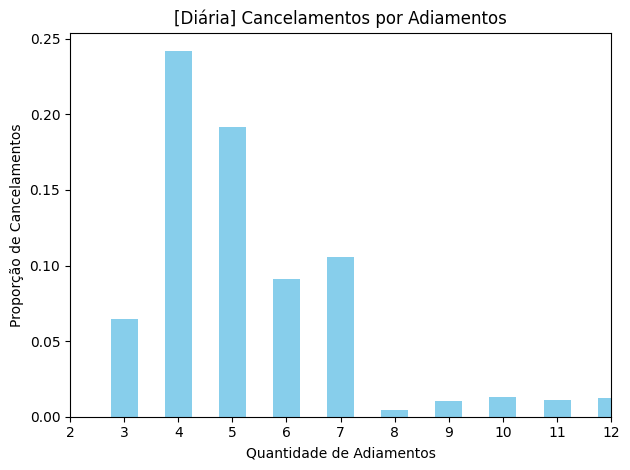


[Diária] Tabela: Ciclo de Atendimento dos Contratos (% por janela)
       Atendido  Postergado  Cancelado
24h   40.989667   10.539753  10.685469
54h   52.791493   14.527084  14.724584
84h   60.991353   16.541824  16.953684
114h  65.530239   17.636504  18.286808
144h  67.931549   18.204918  19.336930
174h  68.834750   18.481900  19.936656
204h  69.232159   18.546930  20.184735
234h  69.583805   18.592693  20.349719


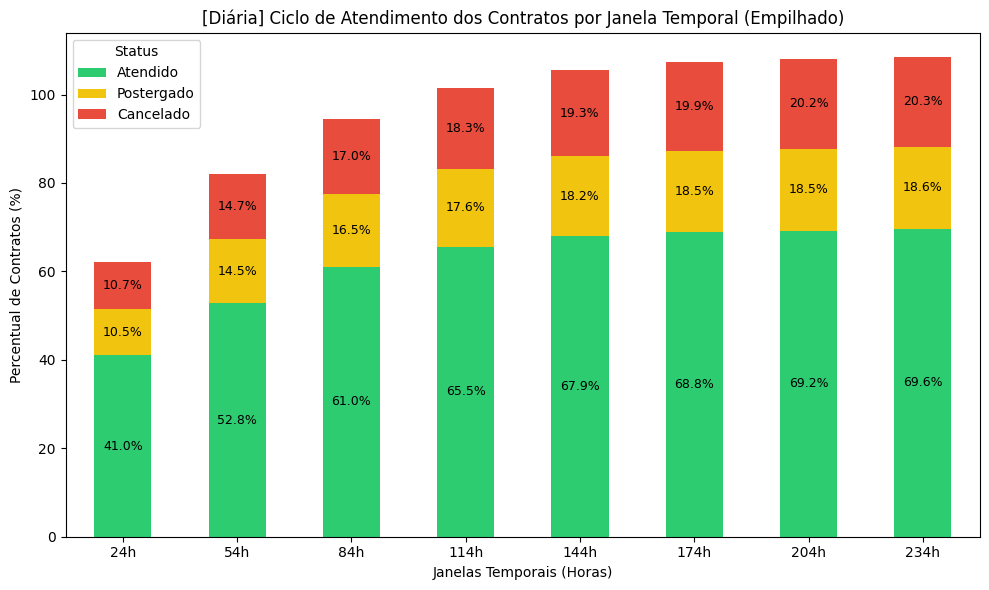

/tmp/ipykernel_81554/3495400494.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tipo['Data da criação do contrato'] = pd.to_datetime(df_tipo['Data da criação do contrato'], format=data_format, errors='coerce')
/tmp/ipykernel_81554/3495400494.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tipo['data do evento'] = pd.to_datetime(df_tipo['data do evento'], format=data_format, errors='coerce')



[Diária] Tabela: Distribuição dos Adiamentos
        Janela  Total de Adiamentos
0  Até 6 horas                61316
1   6-12 horas                19477
2  12-18 horas                19807
3  18-24 horas               188811
4    24+ horas               148549


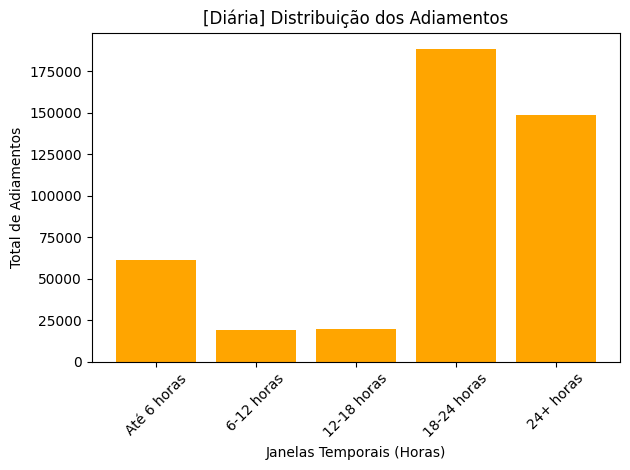


[Diária] Tabela: Proporção de Cancelamentos por Janela de Adiantamento
        Janela  Proporção de Cancelamentos
0  Até 6 horas                    0.224726
1   6-12 horas                    0.219157
2  12-18 horas                    0.232899
3  18-24 horas                    0.339065
4    24+ horas                    0.316204


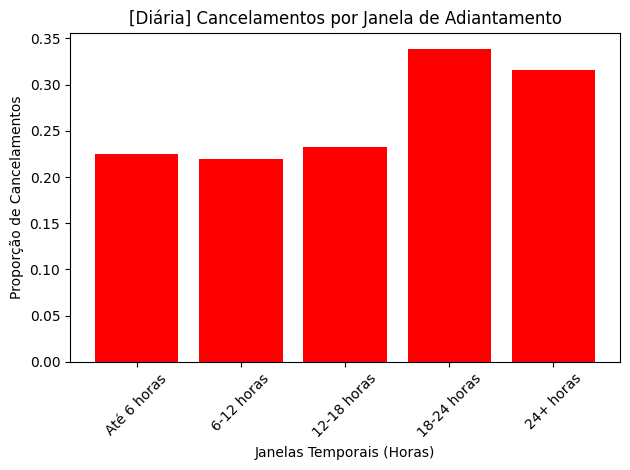


[Coleta/Entrega] Tabela: Proporção de Cancelamentos por Quantidade de Adiamentos
     quantidade_adiamentos  cancelado
0                        2   0.000000
1                        3   0.000000
2                        4   0.249409
3                        5   0.197613
4                        6   0.128965
5                        7   0.119177
6                        8   0.002986
7                        9   0.007776
8                       10   0.010600
9                       11   0.011135
10                      12   0.013438
11                      13   0.006700
12                      14   0.017115
13                      15   0.005287
14                      16   0.041858
15                      17   0.004202
16                      18   0.061947
17                      19   0.005135
18                      20   0.061905
19                      21   0.031746
20                      22   0.040727
21                      23   0.000000
22                      24   0.034396
23    

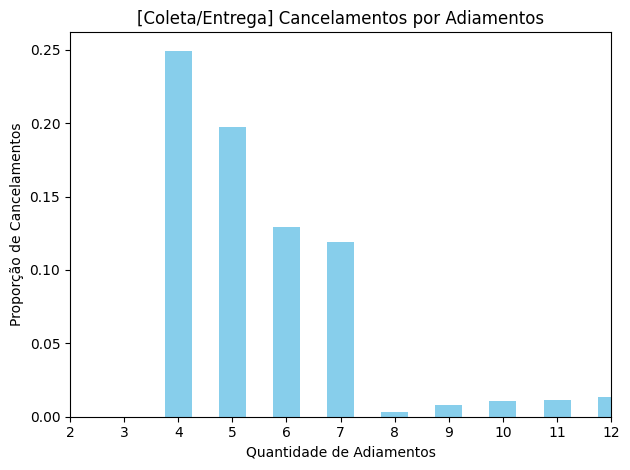


[Coleta/Entrega] Tabela: Ciclo de Atendimento dos Contratos (% por janela)
       Atendido  Postergado  Cancelado
24h   54.269471    8.168524  10.067319
54h   66.467500   10.936997  13.140179
84h   75.030600   12.457321  14.670167
114h  78.483541   13.107969  15.615538
144h  79.638279   13.415577  16.349932
174h  80.123043   13.554081  16.820202
204h  80.358178   13.615281  16.992527
234h  80.548219   13.645880  17.098821


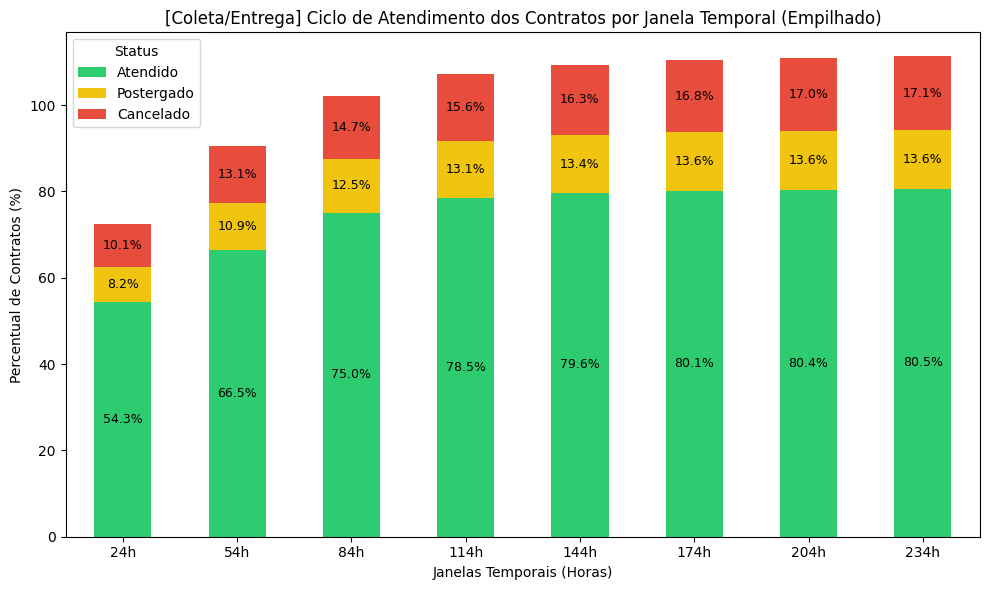

/tmp/ipykernel_81554/3495400494.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tipo['Data da criação do contrato'] = pd.to_datetime(df_tipo['Data da criação do contrato'], format=data_format, errors='coerce')
/tmp/ipykernel_81554/3495400494.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tipo['data do evento'] = pd.to_datetime(df_tipo['data do evento'], format=data_format, errors='coerce')



[Coleta/Entrega] Tabela: Distribuição dos Adiamentos
        Janela  Total de Adiamentos
0  Até 6 horas                20157
1   6-12 horas                 5407
2  12-18 horas                 3074
3  18-24 horas               150380
4    24+ horas                73719


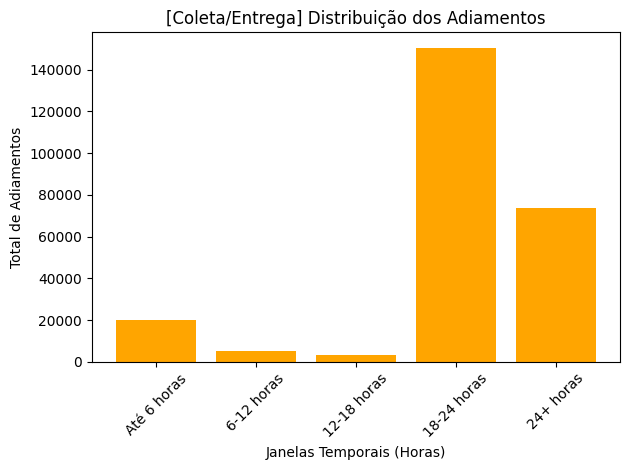


[Coleta/Entrega] Tabela: Proporção de Cancelamentos por Janela de Adiantamento
        Janela  Proporção de Cancelamentos
0  Até 6 horas                    0.310030
1   6-12 horas                    0.155263
2  12-18 horas                    0.199029
3  18-24 horas                    0.380654
4    24+ horas                    0.381570


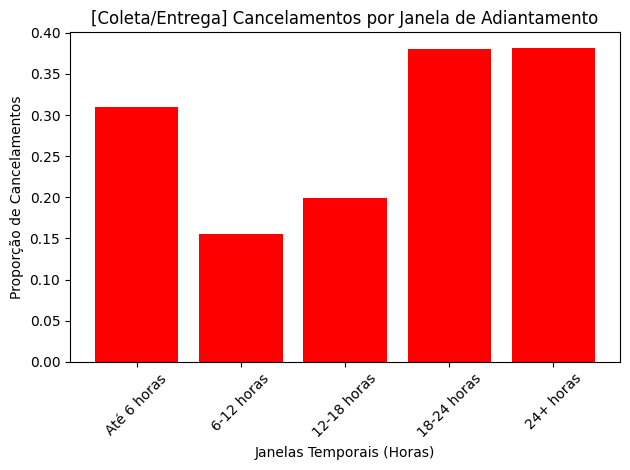

KeyboardInterrupt: 

In [4]:
tipos_contrato = ['Diária', 'Coleta/Entrega', 'Ajudante']
timeline_file = 'src/data/timeline.csv'
days_file = 'src/data/days.csv'

for tipo in tipos_contrato:
    gerar_grafico_cancelamentos_por_adiamentos(timeline_file, days_file, tipo)
    gerar_grafico_ciclo_de_vida(timeline_file, days_file, tipo)
    gerar_grafico_distribuicao_adiamentos(timeline_file, days_file, tipo)
    gerar_grafico_proporcao_cancelamentos_por_adiantamento(timeline_file, days_file, tipo)
